# 用fastGB生成天琴双白矮星信号的实例教程

In [9]:
import numpy as np
import sys, os
import time

import matplotlib.pyplot as plt
#import matplotlib as mpl
#import pandas as pd
from scipy.fftpack import fft,rfft

In [1]:
#from LISAhdf5 import LISAhdf5,ParsUnits
#import tdi
#import FastGB as FB    # 导入fastGB

#import LISAConstants as LC

from fastgb import FastGB as FB
from fastgb import _FastGB as _FB

# 定义用fastGB生成DWD信号的函数

In [2]:
def GenerateFastGB(p, Tobs, Cadence, oversample, TD = False):   # 默认TD = False，即生成频域信号。如果要生成时域信号那么需要标明TD = True
    #{{{
    ### unfolding the parameters and producing the list of Params
    Amp = p[0]
    f0 = p[1]
    fdot = p[2]
    iota = p[3]
    psi = p[4]
    phi0 = p[5]
    EclLat = p[6]
    EclLon = p[7]

    Tobs = Tobs
    del_t = Cadence
    Ns = len(Amp)    # 源的个数

    prm = []
    for i in range(Ns):
        tmp = np.array([f0[i], fdot[i], EclLat[i], EclLon[i], Amp[i], iota[i], psi[i], phi0[i]])
        prm.append(tmp)
    fastB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")

    if TD:
        Xt, Yt, Zt = fastB.TDI(T=Tobs,dt=del_t,simulator='synthlisa',table=prm,
        algorithm='Michele',oversample=oversample)
        tm = np.arange(len(Xt))*del_t

        return (tm, Xt, Yt, Zt)

    else:
        Xf, Yf, Zf = fastB.fourier(T=Tobs,dt=del_t,simulator='synthlisa',
        table=prm,algorithm='Michele',oversample=oversample)
        return(Xf.f,Xf[:],Yf[:],Zf[:])


# J0806单个源

In [13]:
f0=[0.00622028]
fd=[7.48528554e-16]
beta=[-0.082205]  #ecliptic latitude [rad]
Lambda=[2.10225]  #ecliptic longitude [rad]
Amp=[6.37823e-23]
iota=[0.645772]
psi=[2.91617795]
phi0=[3.1716561]

# 两年观测时长，15s采一个点。
# 在fastGB程序中，Tobs=62914560和dt=15是默认值。
# 这个15s的采样间隔是适用于LISA的，但实际操作中并不影响，因为它只是一个缺少输入条件时的默认值而已，你可以在这里输入任何你需要的Cadence值。
# 在这里，仅作为一个初步的例子，我们用了15s的采样间隔。实际天琴的采样间隔可能是1s左右，你可以自行修改成更符合实情的Tobs和Cadence。
Tobs = 62914560.0
Cadence = 15.0

paras = [Amp, f0, fd, iota, psi, phi0, beta, Lambda]

# 调用函数生成频域信号（如果需要时域，则在括号里再加一个TD = True即可）
J0806_FD_highos = GenerateFastGB(paras, Tobs, Cadence, 32768)

# 注意，这里的32768是什么？
# 它是oversample的值，用于调节对“慢项”的降采样的程度。oversample值必须为2的倍数，否则傅里叶变换时无法用gsl_fft函数。
# 在这里，原采样点数62914560/15=4194304，而“慢项”采样点数为128*oversample
# （“128”的值根据Tobs和f0的不同而不同，具体可以本文档最后一部分）
# 如果不进行降采样，则4194304=128*oversample，算出来oversample=32768刚好也是2的倍数，可以直接用。
# 这样，就得到了不进行降采样情况下的J0806双星引力波频域波形。


# 处理得到的数据，方便画图
J0806_FD_highos = np.array(J0806_FD_highos).T
J0806_FD_highos[:,1:] = J0806_FD_highos[:,1:]*2
#df_J0806_highos = pd.DataFrame(np.abs(J0806_FD_highos),columns=['f','TDI X (FD)', 'TDI Y (FD)', 'TDI Z (FD)'])

print(J0806_FD_highos.shape)

Stas <class 'int'> <class 'int'> <class 'float'>
1 finished, 6 s elapsed (0/s)
(2097153, 4)


In [25]:
J0806_FD_highos

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 1.58945719e-08+0.00000000e+00j, -8.05374958e-41+6.67901705e-41j,
         7.19637173e-41+4.52214266e-41j,  8.57376529e-42-1.12011611e-40j],
       [ 3.17891439e-08+0.00000000e+00j, -3.22150674e-40+2.67161513e-40j,
         2.87855658e-40+1.80885962e-40j,  3.42949101e-41-4.48047586e-40j],
       ...,
       [ 3.33333015e-02+0.00000000e+00j,  8.95097623e-31-4.92664604e-29j,
        -2.53087931e-29+1.34555574e-29j,  5.00200832e-29+2.94703192e-29j],
       [ 3.33333174e-02+0.00000000e+00j,  8.95067741e-31-4.92664341e-29j,
        -2.53087714e-29+1.34555542e-29j,  5.00200915e-29+2.94702972e-29j],
       [ 3.33333333e-02+0.00000000e+00j,  8.95056980e-31-4.92664211e-29j,
        -2.53087416e-29+1.34555551e-29j,  5.00200805e-29+2.94702539e-29j]])

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


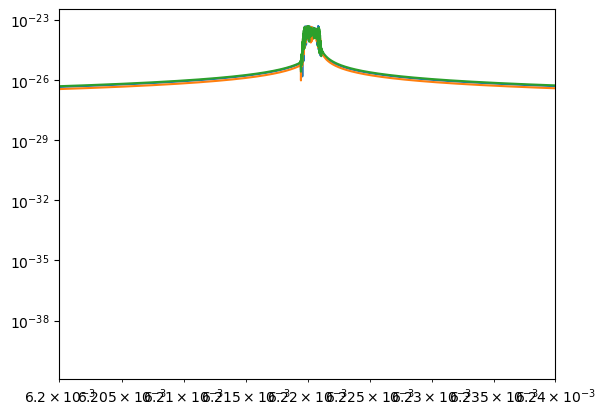

In [44]:
for i in range(1,4):
    #plt.subplot(1,3,i)
    plt.plot(J0806_FD_highos[1:,0], abs(J0806_FD_highos[1:,i]))
    plt.xlim(0.00620,0.00624)
    plt.xscale('log')
    plt.yscale('log')

可以看到这里输出了生成这一个信号所用的时间，约为*O*($10^1$)s（注意这是不进行降采样加速的情况下）

In [16]:
#df_J0806_highos

<font color=blue>我们在这里也生成J0806的时域信号，并进行快速傅里叶变换，将它与上面生成的频域波形对比，看看是否一致</font>

In [34]:
# 生成时域信号

J0806_TD_highos = GenerateFastGB(paras, Tobs, Cadence, 32768, TD = True)
# J0806_TD_highos 是 tuple（元组）类型，里面包含 4 个 array，分别是 t,Xt,Yt,Zt ，每个 array 有 4194304 个元素

J0806_TD_highos = np.array(J0806_TD_highos).T     # 转置为 4194304行 4列，每列分别为：时间序列、X通道、Y通道、Z通道

#dt_J0806 = pd.DataFrame(J0806_TD,columns=['t','TDI X (TD)', 'TDI Y (TD)', 'TDI Z (TD)'])

Stas <class 'int'> <class 'int'> <class 'float'>
1 finished, 6 s elapsed (0/s)


In [35]:
J0806_TD_highos.shape

(4194304, 4)

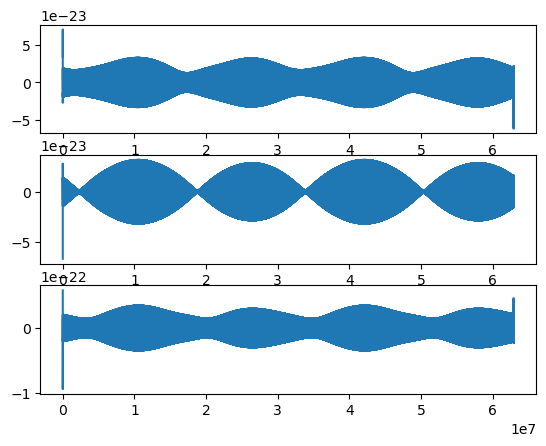

In [41]:
for i in range(1,4):
    plt.subplot(3,1,i)
    plt.plot(J0806_TD_highos[:,0], J0806_TD_highos[:,i])

In [42]:
# 对时域数据FFT，生成振幅谱

# 取 X 通道时域数据
t = J0806_TD_highos[:,0]
X_TD = J0806_TD_highos[:,1]

# 傅里叶变换
X_TD_fft = fft(X_TD)
fs = 1/15
f = np.linspace(0,fs,len(X_TD))   #频域横坐标，最大频率为 fs

# 取复数的绝对值，即复数的模（双边振幅谱）
# 取复数的角度（双边相位谱）
angle_X=np.angle(X_TD_fft)        # 双边相位谱
X_TD_fft = np.abs(X_TD_fft)       # 双边振幅谱

# 振幅谱归一化
X_TD_fft = X_TD_fft / len(X_TD) *2

# 取半
half_f = f[range(int(len(X_TD_fft)/2))]               #取一半区间
X_TD_fft = X_TD_fft[range(int(len(X_TD_fft)/2))]      #单边振幅谱

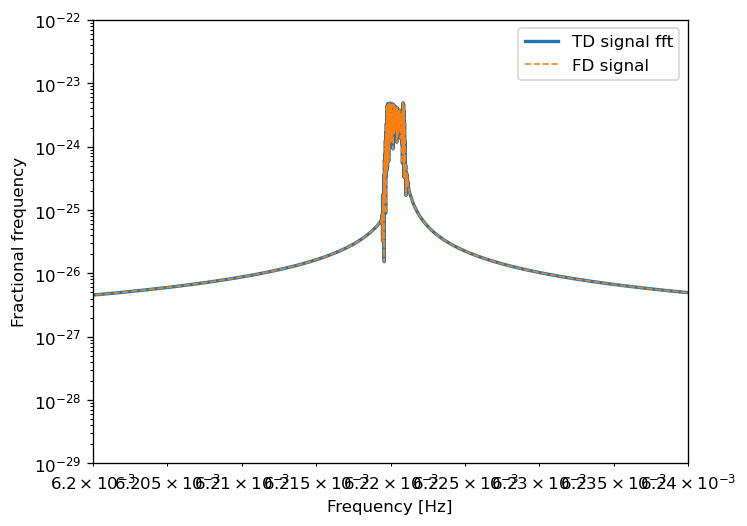

In [50]:
# 画振幅谱，比较由时域数据FFT得来的振幅谱 和 直接生成的频域数据的振幅谱

plt.figure(dpi=120)
plt.loglog(half_f[1:], X_TD_fft[1:], linewidth=2, label='TD signal fft')
plt.loglog(J0806_FD_highos[1:,0] , abs(J0806_FD_highos[1:,1]), '--', linewidth=1, label='FD signal')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Fractional frequency")
plt.xlim(0.00620,0.00624)
plt.ylim(1e-29,1e-22)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# 用卢杨编写的解析生成DWD信号的程序，生成J0806波形，并与fastGB对比

In [9]:
from numpy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import integrate
from scipy.fftpack import fft,rfft

def sinc(parameter):
    sinc = np.sin(parameter)/parameter
    return sinc

def h_X(t,f,beta,Lambda,f_drift, Amp, iota, psi, phi0):

    beta = beta      # 黄纬
    Lambda =Lambda   # 黄经
    f_drift =f_drift
    t=t
    T = max(t)

    # 以下计算q向量要用到：
    Lc = 0.5777499579392          # L/c 自然单位制
    e=0.0167       #地球轨道的偏心率
    yearspersecond = 3.1709791983764586e-8
    alpha = 2*np.pi*t*yearspersecond + (2.102137+np.pi-np.pi/4.0)
    period = 3.65*24*60*60
    isc = 1.652897
    bsc = 2.102137
    beta_1 = 2.0*np.pi*(1-1)/3.0 + 0.0;
    beta_2 = 2.0*np.pi*(2-1)/3.0 + 0.0;
    beta_3 = 2.0*np.pi*(3-1)/3.0 + 0.0;
    gamma_1 = 2.0*np.pi*(t/period) + beta_1
    gamma_2 = 2.0*np.pi*(t/period) + beta_2
    gamma_3 = 2.0*np.pi*(t/period) + beta_3
    
    
    # 以下计算相位phi_t要用到：
    eta_0 =(2.102137+np.pi-np.pi/4.0)     # η0 是t=0时航天器在环太阳轨道上的位置
    omega = 2*np.pi*f                     # 角频率 2Πf
    omegaDerivative = 2*np.pi*f_drift     # omega_dot
    yearspersecond = 3.1709791983764586e-8
    OMRGA = 2*np.pi*yearspersecond
    R = 499.004                           # 1AU = 1.5e11 m /c
    
    # 计算探测器通道响应要用到：
    x = Lc * omega
    
    
    ######################### 航天器相对于guiding-center的位置向量q，忽略偏心率项 ####################################
    
    # x坐标，指标中的前一个数字123分别表示3个航天器
    q_vectors_11 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_1) - np.sin(bsc)*np.sin(gamma_1))
    q_vectors_21 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_2) - np.sin(bsc)*np.sin(gamma_2))
    q_vectors_31 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_3) - np.sin(bsc)*np.sin(gamma_3))
    
    # y坐标
    q_vectors_12 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_1) + np.cos(bsc)*np.sin(gamma_1))
    q_vectors_22 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_2) + np.cos(bsc)*np.sin(gamma_2))
    q_vectors_32 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_3) + np.cos(bsc)*np.sin(gamma_3))
      
    # z坐标
    q_vectors_13 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_1)
    q_vectors_23 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_2)
    q_vectors_33 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_3)
    
    ######################################### 臂长向量n ########################################

    # 向量n1 = q2-q3，三维，臂长1对应的向量
    n_vectors_11 = q_vectors_21 - q_vectors_31
    n_vectors_12 = q_vectors_22 - q_vectors_32
    n_vectors_13 = q_vectors_23 - q_vectors_33
    
    # 向量n2 = q3-q1
    n_vectors_21 = q_vectors_31 - q_vectors_11
    n_vectors_22 = q_vectors_32 - q_vectors_12
    n_vectors_23 = q_vectors_33 - q_vectors_13
    
    # 向量n3 = q1-q2
    n_vectors_31 = q_vectors_11 - q_vectors_21
    n_vectors_32 = q_vectors_12 - q_vectors_22
    n_vectors_33 = q_vectors_13 - q_vectors_23

    
    ##############################    相位函数，包含多普勒调制   ##############################

    phi_t = omega*t + 0.5*omegaDerivative*t**2 + phi0 +(omega + omegaDerivative*t)*R * np.cos(beta) * np.cos(OMRGA*t + eta_0 - Lambda)


    ################# polarization basis in the solar system barycenter frame ##################
    u_vectors_1 = np.sin(beta)*np.cos(Lambda)  # dk/dβ
    u_vectors_2 = np.sin(Lambda)*np.sin(beta)
    u_vectors_3 = -np.cos(beta)

    v_vectors_1 = np.sin(Lambda)
    v_vectors_2 = -np.cos(Lambda)
    v_vectors_3 = 0.0

    
	################# direction of the wave propagation. 波矢 ########################
    k_vectors_1 = -np.cos(Lambda)*np.cos(beta)
    k_vectors_2 = -np.cos(beta)*np.sin(Lambda)
    k_vectors_3 = -np.sin(beta)


    # u标量
    u_scalar_1 = -0.5*((n_vectors_11*u_vectors_1 + n_vectors_12*u_vectors_2 +n_vectors_13*u_vectors_3)**2-\
                            (n_vectors_11*v_vectors_1 + n_vectors_12*v_vectors_2 +n_vectors_13*v_vectors_3)**2)

    u_scalar_2 = -0.5*((n_vectors_21*u_vectors_1 + n_vectors_22*u_vectors_2 +n_vectors_23*u_vectors_3)**2-\
                            (n_vectors_21*v_vectors_1 + n_vectors_22*v_vectors_2 +n_vectors_23*v_vectors_3)**2)

    u_scalar_3 = -0.5*((n_vectors_31*u_vectors_1 + n_vectors_32*u_vectors_2 +n_vectors_33*u_vectors_3)**2-\
                            (n_vectors_31*v_vectors_1 + n_vectors_32*v_vectors_2 +n_vectors_33*v_vectors_3)**2)

    # v标量
    v_scalar_1 = ((n_vectors_11*u_vectors_1 + n_vectors_12*u_vectors_2 +n_vectors_13*u_vectors_3)*\
                       (n_vectors_11*v_vectors_1 + n_vectors_12*v_vectors_2 +n_vectors_13*v_vectors_3))

    v_scalar_2 = ((n_vectors_21*u_vectors_1 + n_vectors_22*u_vectors_2 +n_vectors_23*u_vectors_3)*\
                       (n_vectors_21*v_vectors_1 + n_vectors_22*v_vectors_2 +n_vectors_23*v_vectors_3))

    v_scalar_3 = ((n_vectors_31*u_vectors_1 + n_vectors_32*u_vectors_2 +n_vectors_33*u_vectors_3)*\
                       (n_vectors_31*v_vectors_1 + n_vectors_32*v_vectors_2 +n_vectors_33*v_vectors_3))
    
    
    ####################################### 探测器X通道响应 #######################################################
    
    X_1 = u_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -u_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_2 = v_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -v_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_3 = u_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -u_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_4 = v_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -v_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    # 响应后的信号（只包含内秉参数）
    h1 =2*omega*Lc*np.sin(omega*Lc)*X_1
    h2 =2*omega*Lc*np.sin(omega*Lc)*X_2
    h3 =2*omega*Lc*np.sin(omega*Lc)*X_3
    h4 =2*omega*Lc*np.sin(omega*Lc)*X_4
    h=[h1,h2,h3,h4]
    
    # 外秉部分
    h_zero =Amp
    h_plus = h_zero*(1 + (np.cos(iota))**2)
    h_cross = 2*h_zero*np.cos(iota)
    
    a_1 = h_plus * np.cos(phi0) * np.cos(2*psi) - h_cross*np.sin(phi0)*np.sin(2*psi)
    a_2 = h_plus * np.cos(phi0) * np.sin(2*psi) + h_cross*np.sin(phi0)*np.cos(2*psi)
    a_3 = -h_plus * np.sin(phi0) * np.cos(2*psi) - h_cross*np.cos(phi0)*np.sin(2*psi)
    a_4 = -h_plus * np.sin(phi0) * np.sin(2*psi) + h_cross*np.cos(phi0)*np.cos(2*psi)
    
    TDIX_t=h1*a_1+h2*a_2+h3*a_3+h4*a_4
    
    return TDIX_t



In [10]:
# 注入J0806参数
f0=[0.00622028]
fd=[7.48528554e-16]
beta=[-0.082205]  #ecliptic latitude [rad]
Lambda=[2.10225]  #ecliptic longitude [rad]
Amp=[6.37823e-23]
iota=[0.645772]
psi=[2.91617795]
phi0=[3.1716561]

t=np.arange(0, 62914560, 15)  # 同样取2年观测时长，15s采样间隔

Nsignal = len(f0)   # 信号数量

X = np.zeros((Nsignal,len(t)))
X_t_total = np.zeros(len(t))
for i in range(Nsignal):
    X[i,:]=h_X(t,f0[i],beta[i],Lambda[i],fd[i], Amp[i], iota[i], psi[i], phi0[i])
    X_t_total=X_t_total+X[i,:]

# fft
fs = 1/15
X_f = np.abs(np.fft.rfft(X_t_total))/len(X_t_total)*2
xf = np.linspace(0,fs/2,len(X_f))

In [11]:
err = np.abs(X_f-df_J0806_highos['TDI X (FD)'])

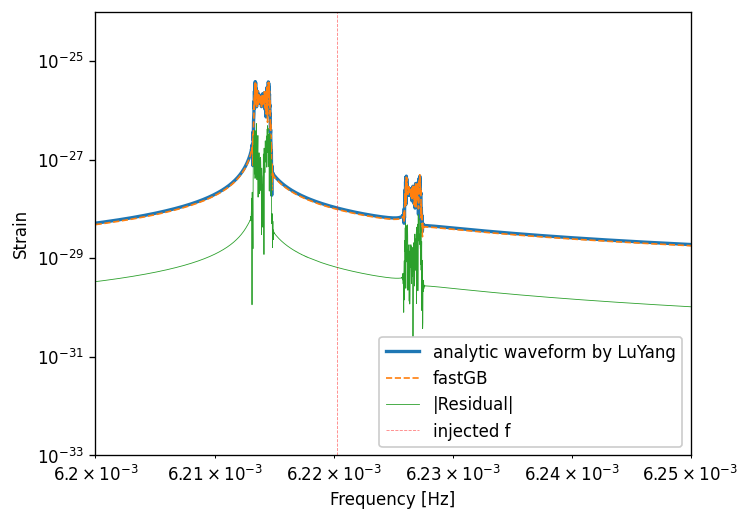

In [12]:
plt.figure(dpi=120)
plt.loglog(xf, X_f, linewidth=2, label='analytic waveform by LuYang')
plt.loglog(df_J0806_highos['f'] , df_J0806_highos['TDI X (FD)'], linestyle='--', linewidth=1, label='fastGB')
plt.loglog(xf, err, linewidth=0.5, label='|Residual|')

plt.axvline(f0[0] ,color='r' ,linestyle='--', linewidth=0.5 , alpha = 0.5 ,label='injected f')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Strain")
plt.xlim(0.00620,0.00625)
plt.ylim(1e-33,1e-24)
plt.legend(loc=4, framealpha=1)
plt.show()

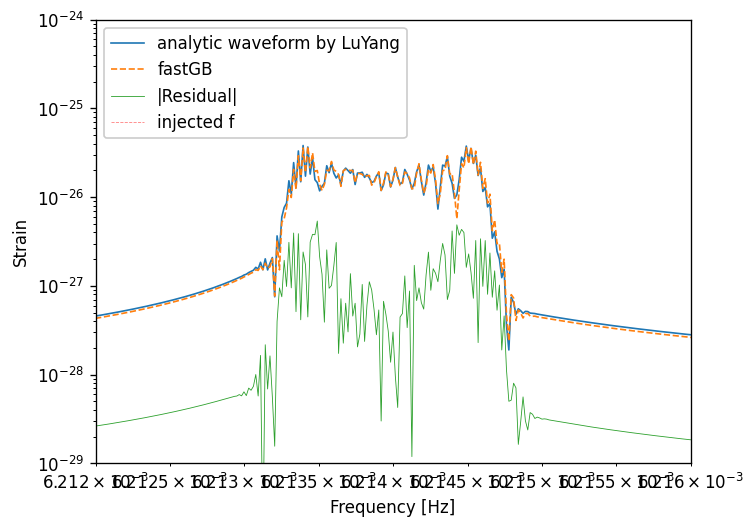

In [13]:
# 放大局部
plt.figure(dpi=120)
plt.loglog(xf, X_f, linewidth=1, label='analytic waveform by LuYang')
plt.loglog(df_J0806_highos['f'] , df_J0806_highos['TDI X (FD)'], linestyle='--', linewidth=1, label='fastGB')
plt.loglog(xf, err, linewidth=0.5, label='|Residual|')

plt.axvline(f0[0] ,color='r' ,linestyle='--', linewidth=0.5 , alpha = 0.5 ,label='injected f')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Strain")
plt.xlim(0.006212,0.006216) #左半边
#plt.xlim(0.006225,0.00623) #右半边
plt.ylim(1e-29,1e-24)

plt.legend(loc=2, framealpha=1)
plt.show()

# 进行降采样加速，即选择更小的oversample值

In [14]:
f0=[0.00622028]
fd=[7.48528554e-16]
beta=[-0.082205]  #ecliptic latitude [rad]
Lambda=[2.10225]  #ecliptic longitude [rad]
Amp=[6.37823e-23]
iota=[0.645772]
psi=[2.91617795]
phi0=[3.1716561]

Tobs = 62914560.0
Cadence = 15.0

paras = [Amp, f0, fd, iota, psi, phi0, beta, Lambda]

# 调用函数生成频域信号
J0806_FD_ds = GenerateFastGB(paras, Tobs, Cadence, 8)

# 在这里，我们选择oversample能取到的最小值8，使“慢项”的采样点数在合理范围内降到最低（为什么最小值是8将在最后详细说明）

# 处理得到的数据，方便画图
J0806_FD_ds = np.array(J0806_FD_ds).T
J0806_FD_ds[:,1:] = J0806_FD_ds[:,1:]*2
df_J0806_ds = pd.DataFrame(np.abs(J0806_FD_ds),columns=['f','TDI X (FD)', 'TDI Y (FD)', 'TDI Z (FD)'])

1 finished, 0.002336 s elapsed (428.164965/s)


<font color=blue>用时从*O*($10^1$)s降到*O*($10^{-3}$)s，显然，计算速度大大加快了。</font>

那么波形的精确度如何呢？

In [15]:
import math
h1 = df_J0806_highos['TDI X (FD)']   # 不进行降采样加速的波形
h2 = df_J0806_ds['TDI X (FD)']       # 降采样加速计算出的波形
h1_h1 = np.dot(h1,h1)
h2_h2 = np.dot(h2,h2)
h2_h1 = np.dot(h2,h1)
Match = h2_h1 / math.sqrt(h2_h2*h1_h1)
Match

0.9994921931257879

<font color=blue>加速后的波形与未加速时的匹配度达到99.9%，说明降采样并不会大幅影响我们生成波形的准确性。</font>

需要说明的是，如果oversample的取值继续缩小，例如取4、2、1，那么生成波形的准确性就会变得很差（如下所示）。

In [16]:
J0806_FD_overds = GenerateFastGB(paras, Tobs, Cadence, 4)

J0806_FD_overds = np.array(J0806_FD_overds).T
J0806_FD_overds[:,1:] = J0806_FD_overds[:,1:]*2
df_J0806_overds = pd.DataFrame(np.abs(J0806_FD_overds),columns=['f','TDI X (FD)', 'TDI Y (FD)', 'TDI Z (FD)'])

h1 = df_J0806_highos['TDI X (FD)']   # 不进行降采样加速的波形
h2 = df_J0806_overds['TDI X (FD)']   # 过度降采样加速计算出的波形
h1_h1 = np.dot(h1,h1)
h2_h2 = np.dot(h2,h2)
h2_h1 = np.dot(h2,h1)
Match = h2_h1 / math.sqrt(h2_h2*h1_h1)
print("Match=",Match)

1 finished, 0.002197 s elapsed (455.111111/s)
Match= 0.004405048904734233


这是为什么呢？

# oversample的取值

我们知道，当对一个频率为 $f_{example}$ 的信号进行采样时，采样频率必须至少为它的两倍，即 $f_s \geq 2f_{example}$ ，才能不“错过”波形中包含的信息。\
对于天琴来说，三个探测器绕质心旋转的周期为3.65天，而探测器每旋转一圈，响应就旋转了两圈，因此 $\omega_{response} = 2\omega_{orbit} = 6.34e-6$

In [17]:
1/(3.65*24*60*60) *2

6.341958396752917e-06

信号的“慢项”中包含了探测器响应等信息，对于“慢项”的采样，如前所述，采样频率必须至少为 $\omega_{response}$ 的两倍：\
$f_s \geq 1.268e-5$

In [18]:
2*6.341958396752917e-06

1.2683916793505835e-05

对于两年的观测时长 $T_{obs} = 6.29e7$ ，采样点数 N ，则采样频率 $f_s = N/T_{obs}$ ，可以算出 $N \geq 798$

In [19]:
62914560*1.2683916793505835e-05

798.0030441400304

由于 N 必须为 2 的倍数，因此 N 可以取到的最小值是 1024。

根据 <font color=red>FastGB.py 中的 buffersize 函数</font>：\
$N = m * n * oversample$\
\
当 $T_{obs} \leq 1yr$，$m=1$\
当 $1yr < T_{obs} \leq 2yr$，$m=2$\
当 $2yr < T_{obs} \leq 4yr$，$m=4$\
当 $4yr < T_{obs} \leq 8yr$，$m=8$\
\
当 $f_{0} \leq 0.001Hz$，$n=32$\
当 $0.001Hz < f_{0} \leq 0.01Hz$，$n=64$\
当 $0.01Hz < f_{0} \leq 0.03Hz$，$n=256$\
当 $0.03Hz < f_{0} \leq 0.1Hz$，$n=512$\
当 $f_{0} > 0.1Hz$，$n=1024$\
\
现在，$T_{obs}=2yr$，$f_0 = 0.00622Hz$，故采样点数 $N = 2*64*oversample = 128*oversample$ 。

因此 oversample 可以取到最小值是 $1024/128=8$。\
如果再小，那么就无法满足 $f_s \geq 2\omega_{response}$ 的条件，得到的波形就不可靠了。

显然，对于信号频率不同、观测时长不同的情况，N 和 oversample 的最小取值都会不一样。如上所述，你可以根据观测时长算出 N 的最小取值，再根据 FastGB.py 中的 buffersize 函数判断 oversample 的相应取值。\
总体来说，对于 4 年及以下的观测时长、mHz 频段的引力波信号，oversample 只要取到 64 及以上就是“安全”的，具体能取多小就请自己根据 buffersize 函数来判断了。